In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#LOAD IN FILES

df_plant1_gen = pd.read_csv("data/Plant_1_Generation_Data.csv")
df_plant1_sensor = pd.read_csv("data/Plant_1_Weather_Sensor_Data.csv")

In [3]:
#REFORMAT DATETIME COLUMN IN BOTH DATASETS

df_plant1_gen['DATE_TIME'] = pd.to_datetime(
    df_plant1_gen['DATE_TIME'],
    format='%d-%m-%Y %H:%M'
)
df_plant1_gen['DATE_TIME'] = df_plant1_gen['DATE_TIME'].dt.strftime(
    '%m-%d-%Y %H:%M'
)

df_plant1_sensor['DATE_TIME'] = pd.to_datetime(
    df_plant1_sensor['DATE_TIME'],
    format='%Y-%m-%d %H:%M:%S'
)
df_plant1_sensor['DATE_TIME'] = df_plant1_sensor['DATE_TIME'].dt.strftime(
    '%m-%d-%Y %H:%M'
)

display(df_plant1_gen.head())
display(df_plant1_sensor.head())

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,05-15-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,05-15-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,05-15-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,05-15-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,05-15-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,05-15-2020 00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,05-15-2020 00:15,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,05-15-2020 00:30,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,05-15-2020 00:45,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,05-15-2020 01:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [4]:
%%sql
--FEATURE ENGINEERING 1
--SQL query with aggregate features

WITH inv AS (
  SELECT COUNT(DISTINCT SOURCE_KEY) AS num_inv
  FROM df_plant1_gen
),
agg AS (
  SELECT
    DATE_TIME,
    SUM(DC_POWER) AS PLANT_DC_PWR,
    SUM(AC_POWER) AS PLANT_AC_PWR,
    AVG(AC_POWER) AS AVG_AC,
    STDDEV(AC_POWER) AS STD_AC,
    MIN(AC_POWER) AS MIN_AC,
    MAX(AC_POWER) AS MAX_AC,
    SUM(DAILY_YIELD) AS PLANT_DAILY_YIELD,
    COUNT(AC_POWER) AS ACTIVE_INV,
    AVG(CASE WHEN AC_POWER = 0 THEN 1.0 ELSE 0.0 END) AS INV_ZERO_FRAC
  FROM df_plant1_gen
  GROUP BY DATE_TIME
)
SELECT
  a.*,
  a.ACTIVE_INV * 1.0 / i.num_inv AS ACTIVE_INV_FRAC
FROM agg a
CROSS JOIN inv i
ORDER BY a.DATE_TIME;


,DATE_TIME,PLANT_DC_PWR,PLANT_AC_PWR,AVG_AC,STD_AC,MIN_AC,MAX_AC,PLANT_DAILY_YIELD,ACTIVE_INV,INV_ZERO_FRAC,ACTIVE_INV_FRAC
0,05-15-2020 00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21,1.0,0.954545
1,05-15-2020 00:15,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21,1.0,0.954545
2,05-15-2020 00:30,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21,1.0,0.954545
3,05-15-2020 00:45,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21,1.0,0.954545
4,05-15-2020 01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,22,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
3153,06-17-2020 22:45,0.0,0.0,0.0,0.0,0.0,0.0,129571.000000,22,1.0,1.000000
3154,06-17-2020 23:00,0.0,0.0,0.0,0.0,0.0,0.0,129571.000000,22,1.0,1.000000
3155,06-17-2020 23:15,0.0,0.0,0.0,0.0,0.0,0.0,129571.000000,22,1.0,1.000000
3156,06-17-2020 23:30,0.0,0.0,0.0,0.0,0.0,0.0,129571.000000,22,1.0,1.000000


In [5]:
#FEATURE ENGINEERING 2

#merge tables
df1_merge = df_plant1_sensor[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
df2_merge = df_plant1_gen_agg.drop('ACTIVE_INV', axis=1)
df_features = pd.merge(df1_merge, df2_merge, on='DATE_TIME')

#reformat date in merged table
df_features['DATE_TIME'] = pd.to_datetime(
    df_features['DATE_TIME'],
    format='%m-%d-%Y %H:%M'
)

#time features
interval_index = (df_features['DATE_TIME'].dt.hour * 4) + (df_features['DATE_TIME'].dt.minute // 15)
df_features['TOD_SIN'] = np.sin(2 * np.pi * interval_index / 96)
df_features['TOD_COS'] = np.cos(2 * np.pi * interval_index / 96)

#lag and rolling features
df_features['IRRADIATION_LAG1'] = df_features['IRRADIATION'].shift(1)
df_features['IRRADIATION_LAG2'] = df_features['IRRADIATION'].shift(2)
df_features['IRRADIATION_ROLLMEAN_1H'] = df_features['IRRADIATION'].rolling(4).mean()
df_features['IRRADIATION_ROLLSTD_1H'] = df_features['IRRADIATION'].rolling(4).std()
df_features['MODTEMP_LAG1'] = df_features['MODULE_TEMPERATURE'].shift(1)
df_features['MODTEMP_ROLLMEAN_1H'] = df_features['MODULE_TEMPERATURE'].rolling(4).mean()

df_features['AC_PWR_LAG1'] = df_features['PLANT_AC_PWR'].shift(1)
df_features['AC_PWR_LAG2'] = df_features['PLANT_AC_PWR'].shift(2)
df_features['AC_PWR_LAG4'] = df_features['PLANT_AC_PWR'].shift(4)
df_features['AC_PWR_ROLLMEAN_1H'] = df_features['PLANT_AC_PWR'].rolling(4).mean()
df_features['AC_PWR_ROLLSTD_1H'] = df_features['PLANT_AC_PWR'].rolling(4).std()
df_features['AC_PWR_RAMP'] = df_features['AC_PWR_LAG1'] - df_features['AC_PWR_LAG2']


df_features

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_DC_PWR,PLANT_AC_PWR,AVG_AC,STD_AC,MIN_AC,MAX_AC,...,IRRADIATION_ROLLMEAN_1H,IRRADIATION_ROLLSTD_1H,MODTEMP_LAG1,MODTEMP_ROLLMEAN_1H,AC_PWR_LAG1,AC_PWR_LAG2,AC_PWR_LAG4,AC_PWR_ROLLMEAN_1H,AC_PWR_ROLLSTD_1H,AC_PWR_RAMP
0,2020-05-15 00:00:00,25.184316,22.857507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-15 00:15:00,25.084589,22.761668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,22.857507,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2020-05-15 00:30:00,24.935753,22.592306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,22.761668,NaN,0.0,0.0,NaN,NaN,NaN,0.0
3,2020-05-15 00:45:00,24.846130,22.360852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.592306,22.643083,0.0,0.0,NaN,0.0,0.0,0.0
4,2020-05-15 01:00:00,24.621525,22.165423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.360852,22.470062,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,22.150570,21.480377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.080829,21.060298,0.0,0.0,0.0,0.0,0.0,0.0
3153,2020-06-17 23:00:00,22.129816,21.389024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.480377,21.116376,0.0,0.0,0.0,0.0,0.0,0.0
3154,2020-06-17 23:15:00,22.008275,20.709211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,21.389024,21.164860,0.0,0.0,0.0,0.0,0.0,0.0
3155,2020-06-17 23:30:00,21.969495,20.734963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.709211,21.078394,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#TARGET ENGINEERING
#predict yield for future horizons (defined in horizons list below)

df_features["DATE"] = df_features["DATE_TIME"].dt.date

# incremental yield within each day
df_features["YIELD_INC"] = df_features.groupby("DATE")["PLANT_DAILY_YIELD"].diff()

# handle first row of each day (diff is NaN). Often this should be the first observed cumulative.
df_features["YIELD_INC"] = df_features["YIELD_INC"].fillna(0)
df_features["YIELD_INC"] = df_features["YIELD_INC"].clip(lower=0)

#predict for 15mins, 30mins, 1hr, 2hr, 4hr ahead
horizons = [1, 2, 4, 8, 16]

for h in horizons:
    df_features[f"Y_TARGET_h{h}"] = (
        df_features.groupby("DATE")["YIELD_INC"].shift(-h)
    )
target_cols = [f"Y_TARGET_h{h}" for h in horizons]
df_features = df_features.dropna(subset=target_cols)

df_features[['DATE_TIME', 'PLANT_DAILY_YIELD', 'YIELD_INC', 'Y_TARGET_h1', 'Y_TARGET_h2', 'Y_TARGET_h4', 'Y_TARGET_h8', 'Y_TARGET_h16']]

,DATE_TIME,PLANT_DAILY_YIELD,YIELD_INC,Y_TARGET_h1,Y_TARGET_h2,Y_TARGET_h4,Y_TARGET_h8,Y_TARGET_h16
0,2020-05-15 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,2020-05-15 00:15:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,2020-05-15 00:30:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,2020-05-15 00:45:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,2020-05-15 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3136,2020-06-17 18:45:00,129571.0,11.285714,0.0,0.0,0.0,0.0,0.0
3137,2020-06-17 19:00:00,129571.0,0.000000,0.0,0.0,0.0,0.0,0.0
3138,2020-06-17 19:15:00,129571.0,0.000000,0.0,0.0,0.0,0.0,0.0
3139,2020-06-17 19:30:00,129571.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error

feature_cols = [
    'AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION',
    'INV_ZERO_FRAC','ACTIVE_INV_FRAC','TOD_SIN','TOD_COS',
    'IRRADIATION_LAG1','IRRADIATION_LAG2','IRRADIATION_ROLLMEAN_1H','IRRADIATION_ROLLSTD_1H',
    'MODTEMP_LAG1','MODTEMP_ROLLMEAN_1H',
    'AC_PWR_LAG1','AC_PWR_LAG2','AC_PWR_LAG4','AC_PWR_ROLLMEAN_1H','AC_PWR_ROLLSTD_1H','AC_PWR_RAMP',
    'PLANT_DC_PWR','PLANT_AC_PWR','AVG_AC','STD_AC','MIN_AC','MAX_AC',
]

# build final modeling frame
model_df = df_features.dropna(subset=feature_cols + target_cols).copy()

#X/y splitting
X = model_df[feature_cols]
y = model_df[target_cols]

display(X.head())

#train/test splitting
split_idx = int(len(model_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

tscv = TimeSeriesSplit(n_splits=5)

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,INV_ZERO_FRAC,ACTIVE_INV_FRAC,TOD_SIN,TOD_COS,IRRADIATION_LAG1,IRRADIATION_LAG2,IRRADIATION_ROLLMEAN_1H,...,AC_PWR_LAG4,AC_PWR_ROLLMEAN_1H,AC_PWR_ROLLSTD_1H,AC_PWR_RAMP,PLANT_DC_PWR,PLANT_AC_PWR,AVG_AC,STD_AC,MIN_AC,MAX_AC
4,24.621525,22.165423,0.0,1.0,1.000000,0.258819,0.965926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,24.536092,21.968571,0.0,1.0,0.954545,0.321439,0.946930,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,24.638674,22.352926,0.0,1.0,0.954545,0.382683,0.923880,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,24.873022,23.160919,0.0,1.0,1.000000,0.442289,0.896873,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,24.936930,23.026113,0.0,1.0,0.954545,0.500000,0.866025,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#RIDGE REGRESSION

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_param_grid = {"model__alpha": np.logspace(-4, 4, 25)}

ridge = GridSearchCV(
    ridge_pipe,
    ridge_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

ridge_models = {}

for h in horizons:
    target = y_train[f"Y_TARGET_h{h}"]

    ridge.fit(X_train, target)
    ridge_models[h] = ridge

In [9]:
#ELASTIC NET REGRESSION

enet_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

enet_param_grid = {
    "model__alpha": np.logspace(-4, 4, 15),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

enet = GridSearchCV(
    enet_pipe,
    enet_param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

enet_models = {}

for h in horizons:
    target = y_train[f"Y_TARGET_h{h}"]

    enet.fit(X_train, target)
    enet_models[h] = enet

In [10]:
#XGBOOST

from xgboost import XGBRegressor

xgb_models = {}

for h in horizons:
    target = y_train[f"Y_TARGET_h{h}"]

    xgb = GridSearchCV(
        XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            random_state=42,
            n_jobs=-1
        ),
        {
            "max_depth": [5, 7],
            "learning_rate": [0.03, 0.05],
            "subsample": [0.8],
            "colsample_bytree": [0.8, 1.0],
            "min_child_weight": [1, 5],
            "reg_lambda": [1, 10]
        },
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    xgb.fit(X_train, target)
    print(f"XGB best params h = {h}:", xgb.best_params_)
    xgb_models[h] = xgb

XGB best params h = 1: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'reg_lambda': 10, 'subsample': 0.8}
XGB best params h = 2: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'reg_lambda': 10, 'subsample': 0.8}
XGB best params h = 4: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'reg_lambda': 10, 'subsample': 0.8}
XGB best params h = 8: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'reg_lambda': 10, 'subsample': 0.8}
XGB best params h = 16: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'reg_lambda': 10, 'subsample': 0.8}


In [11]:
#LIGHTGBM

from lightgbm import LGBMRegressor
'''
lgbm = GridSearchCV(
    LGBMRegressor(
        n_estimators=2000,
        random_state=42,
        n_jobs=-1
    ),
    {
        "learning_rate": [0.02, 0.05, 0.1],
        "num_leaves": [15, 31, 63],
        "min_child_samples": [10, 30, 60],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_lambda": [0.0, 1.0, 5.0]
    },
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
}
'''

'''lgbm = GridSearchCV(
    LGBMRegressor(
        n_estimators=2000,
        random_state=42,
        n_jobs=-1
    ),
    {
        "learning_rate": [0.02],
        "num_leaves": [15],
        "min_child_samples": [60],
        "subsample": [0.8],
        "colsample_bytree": [1.0],
        "reg_lambda": [5.0]
    },
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

lgbm.fit(X_train, y_train)
print("LGBM best params:", lgbm.best_params_)'''

lgbm_models = {}

for h in horizons:
    target = y_train[f"Y_TARGET_h{h}"]

    lgbm = GridSearchCV(
        LGBMRegressor(
            n_estimators=2000,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ),
        {
            "learning_rate": [0.02],
            "num_leaves": [15, 31],
            "min_child_samples": [60],
            "subsample": [0.8],
            "colsample_bytree": [0.8, 1.0],
            "reg_lambda": [5.0]
        },
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    lgbm.fit(X_train, target)
    print(f"LGBM best params h = {h}:", lgbm.best_params_)
    lgbm_models[h] = lgbm

LGBM best params h = 1: {'colsample_bytree': 1.0, 'learning_rate': 0.02, 'min_child_samples': 60, 'num_leaves': 15, 'reg_lambda': 5.0, 'subsample': 0.8}
LGBM best params h = 2: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'min_child_samples': 60, 'num_leaves': 31, 'reg_lambda': 5.0, 'subsample': 0.8}
LGBM best params h = 4: {'colsample_bytree': 1.0, 'learning_rate': 0.02, 'min_child_samples': 60, 'num_leaves': 15, 'reg_lambda': 5.0, 'subsample': 0.8}
LGBM best params h = 8: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'min_child_samples': 60, 'num_leaves': 31, 'reg_lambda': 5.0, 'subsample': 0.8}
LGBM best params h = 16: {'colsample_bytree': 1.0, 'learning_rate': 0.02, 'min_child_samples': 60, 'num_leaves': 15, 'reg_lambda': 5.0, 'subsample': 0.8}


In [13]:
#MODEL EVALUATION

model_groups = {
    "Ridge": ridge_models,
    "ElasticNet": enet_models,
    "XGBoost": xgb_models,
    "LightGBM": lgbm_models
}

results = []

for model_name, models in model_groups.items():
    row = {"Model": model_name}

    for h in horizons:
        preds = models[h].predict(X_test)
        mae = mean_absolute_error(y_test[f"Y_TARGET_h{h}"], preds)
        row[f"h={h}"] = mae

    results.append(row)

results_df = pd.DataFrame(results)
results_df

,Model,h=1,h=2,h=4,h=8,h=16
0,Ridge,1795.701060,1690.769856,1473.207322,1084.182444,787.241340
1,ElasticNet,1795.612120,1690.397269,1472.628507,1085.089523,787.907441
2,XGBoost,244.733765,398.163446,446.238086,529.498894,559.022968
3,LightGBM,242.450600,426.593693,496.731825,584.981309,676.555544


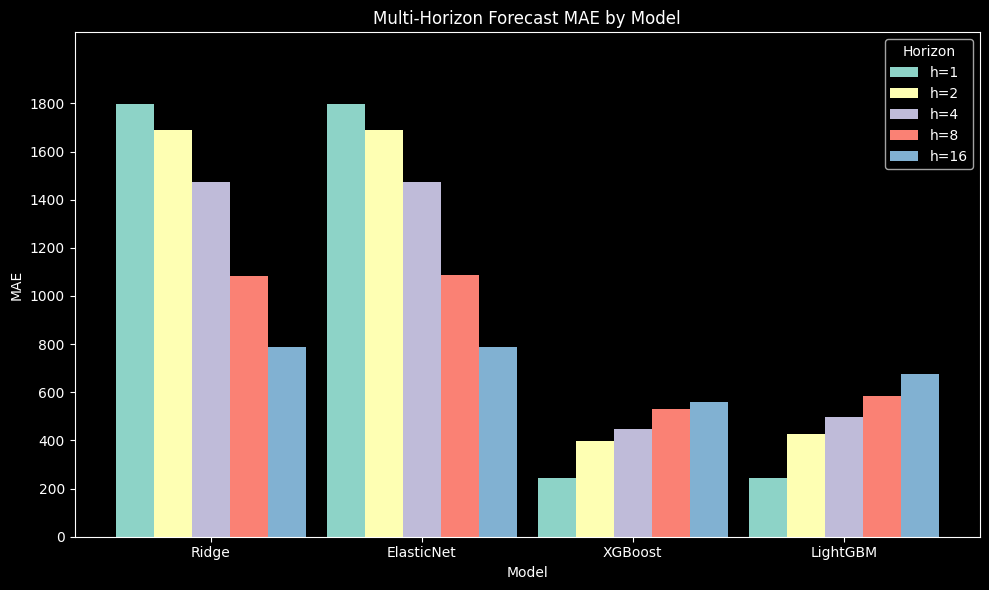

In [16]:
#GRAPH PERFORMANCE METRICS

models_l = results_df['Model']
horizons_l = results_df.columns.tolist()[1:]

x = np.arange(len(models_l))          # model positions
width = 0.18

plt.figure(figsize=(10, 6))

for i, h in enumerate(horizons_l):
    plt.bar(
        x + i * width,
        results_df[h].values,
        width,
        label=h
    )

y_max = results_df.drop('Model', axis=1).max().max()
step = y_max / 6
ticks = np.arange(0, y_max + 50, 200)

plt.ylim(0, y_max + step)
plt.yticks(ticks)

plt.xticks(x + width * (len(horizons_l) - 1) / 2, models_l)

plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("Multi-Horizon Forecast MAE by Model")
plt.legend(title="Horizon")

plt.tight_layout()
plt.show()

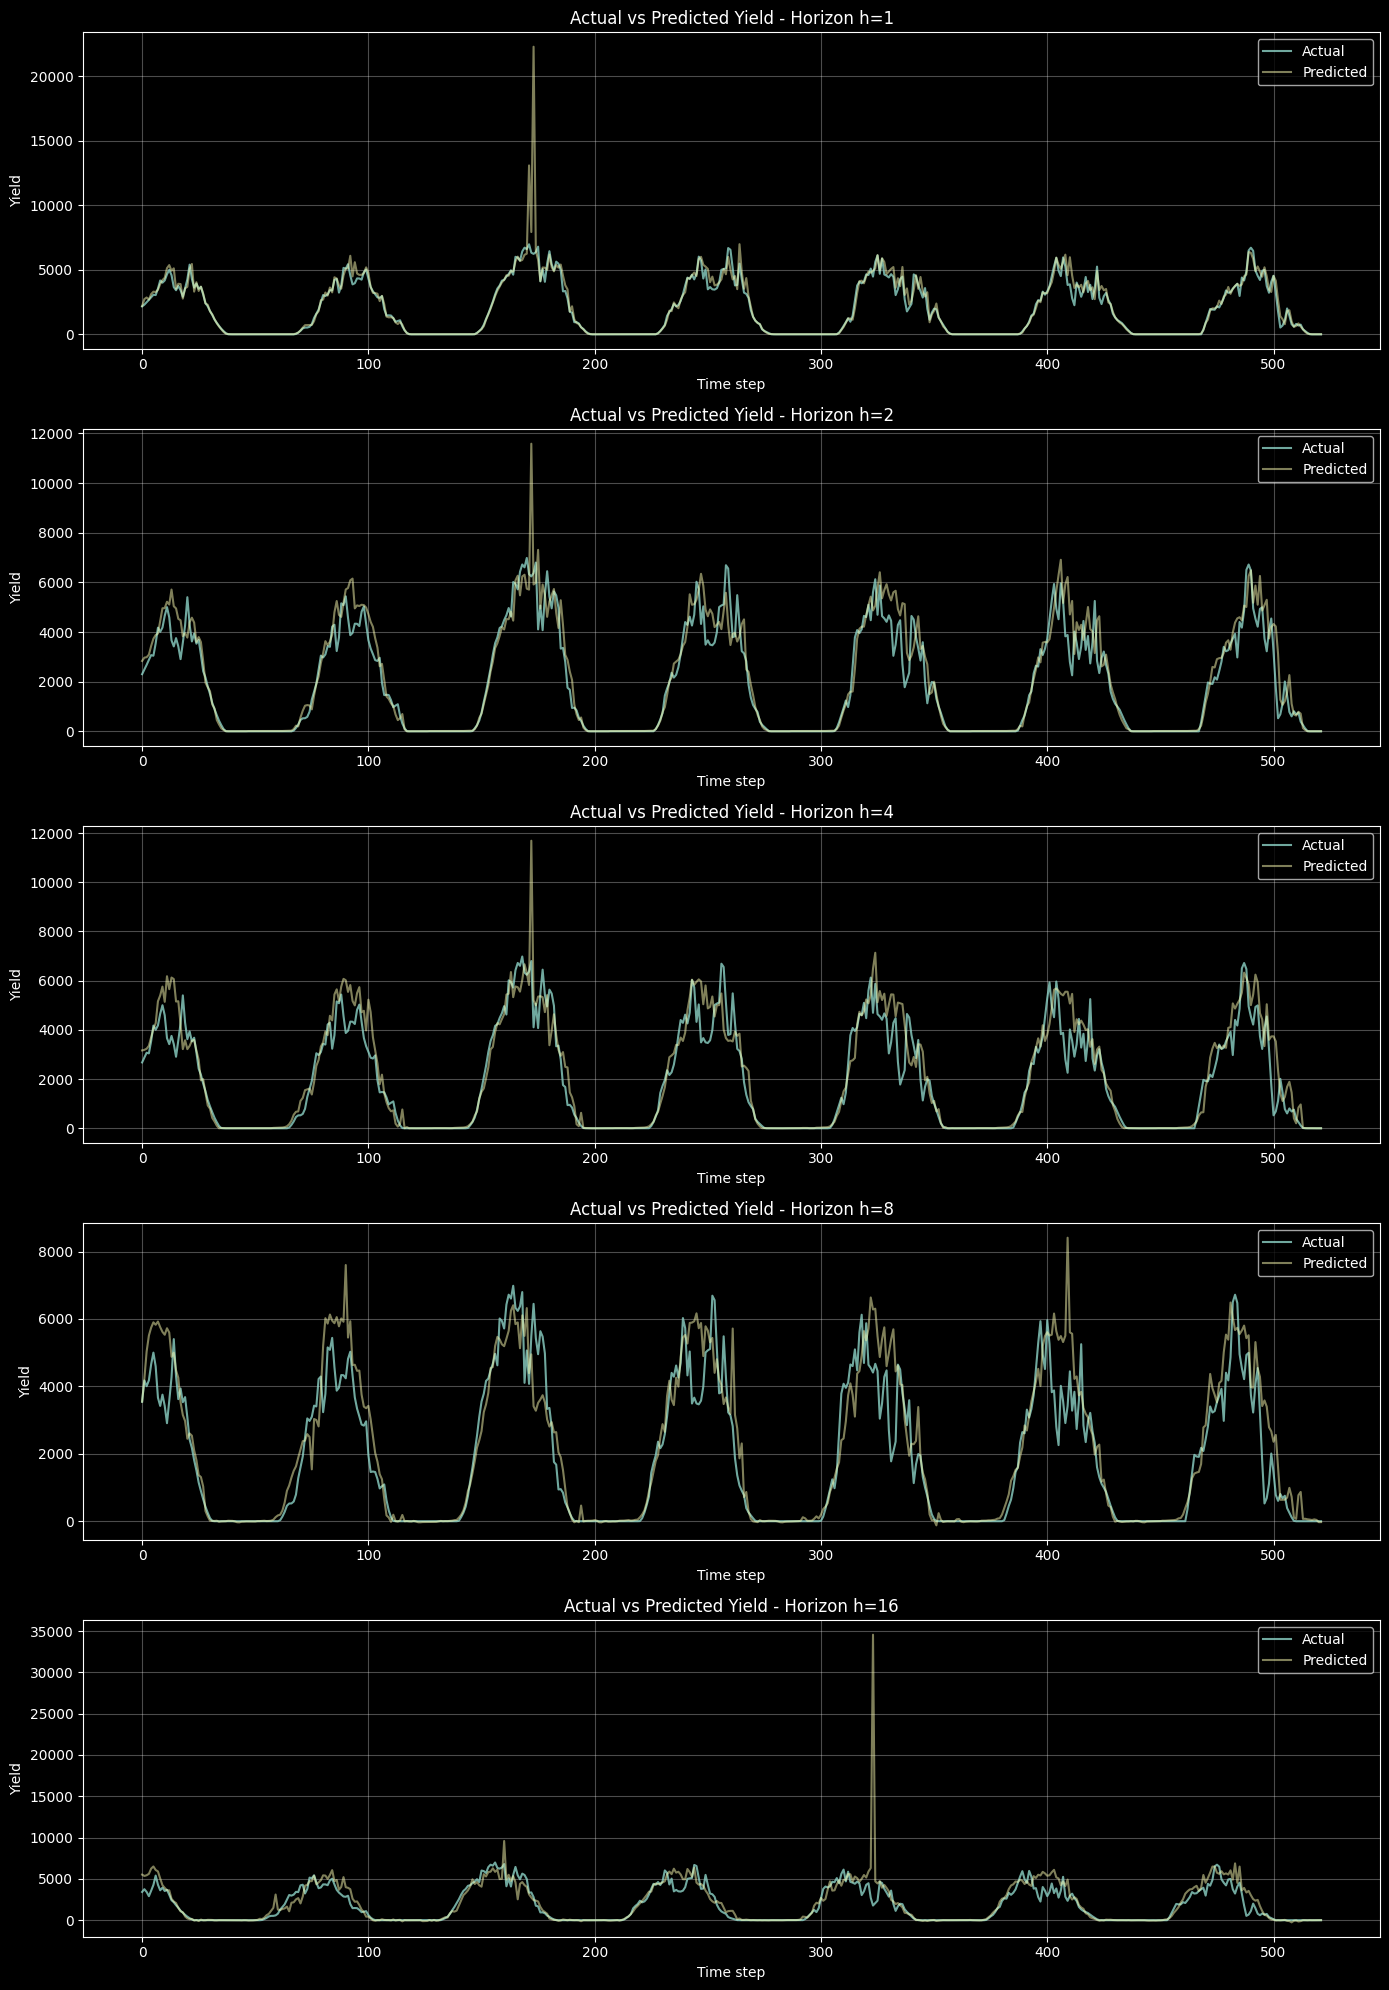

In [17]:
#ACTUAL VS PREDICTION GRAPHS FOR XGBOOST

n_horizons = len(horizons)

fig, axes = plt.subplots(n_horizons, 1, figsize=(14, 4 * n_horizons))

for i, h in enumerate(horizons):
    target_col = f"Y_TARGET_h{h}"
    pred_col = f"Y_TARGET_h{h}"  # Adjust based on your prediction structure\

    xgb_pred = xgb_models[h].predict(X_test)
    axes[i].plot(y_test[target_col].values, label="Actual", alpha=0.8)
    axes[i].plot(xgb_pred, label="Predicted", alpha=0.5)

    axes[i].set_xlabel("Time step")
    axes[i].set_ylabel("Yield")
    axes[i].set_title(f"Actual vs Predicted Yield - Horizon h={h}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()